In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [84]:
from math import ceil
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from project.io import IntakeESMLoader
from project.plotting import plot_field
from project.util import stack_state, unstack_state, is_dask_array
from project.eof import EOF
from project.spaces import PhysicalSpaceForecastSpaceMapper, Detrend, NanMask

In [3]:
ds = xr.open_dataset("/home/enkf6/dstiller/test_io_output.nc", chunks=dict(time=1))[
    ["ohc700", "tas", "psl", "pr"]
]

/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 480, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [178]:
y = stack_state(ds.isel(time=slice(None, 10)))
mask = NanMask()
mask.fit(y)
(y - mask.backward(mask.forward(y))).sum().compute()

<xarray.DataArray ()>
array(0.)

In [139]:
data = ds["psl"].isel(time=slice(None, 100)).dropna("lat")
data = stack_state(data)
data -= data.mean(dim="time")
data

<xarray.DataArray '' (state: 15840, time: 100)>
dask.array<sub, shape=(15840, 100), dtype=float32, chunksize=(15840, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7009-04-16 00:00:00
  * state    (state) object MultiIndex
  * field    (state) object 'psl' 'psl' 'psl' 'psl' ... 'psl' 'psl' 'psl' 'psl'
  * lon      (state) float64 0.0 0.0 0.0 0.0 0.0 ... 358.0 358.0 358.0 358.0
  * lat      (state) float64 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    units:          Pa
    realm:          atmos
    regrid_method:  bilinear

In [140]:
eof = EOF(3)
eof.fit(data)

DEBUG:project.eof:Calculating EOFs using Dask


In [134]:
eof.project_forwards(data.isel(time=0))

<xarray.DataArray (state_eof: 3)>
array([ 48763.855, -10420.422, -28126.951], dtype=float32)
Coordinates:
  * state_eof  (state_eof) int64 0 1 2

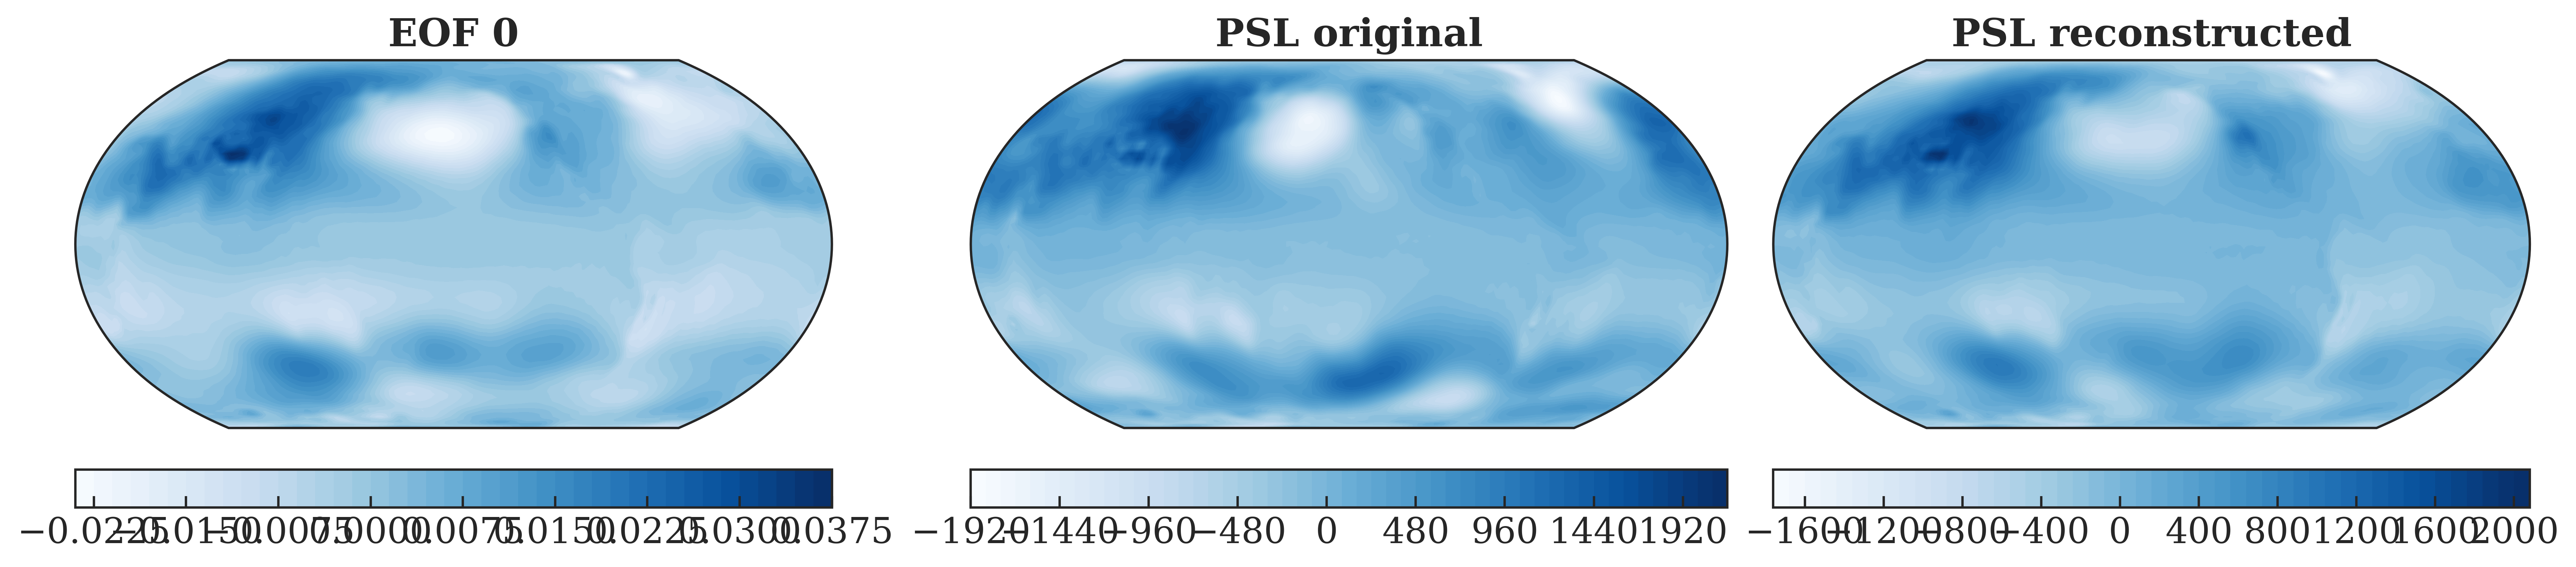

In [136]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("EOF 0")
plot_field(axs[0], unstack_state(eof.get_component(0))["psl"].T)

axs[1].set_title("PSL original")
plot_field(axs[1], unstack_state(data.isel(time=0))["psl"].T)

axs[2].set_title("PSL reconstructed")
plot_field(
    axs[2],
    unstack_state(eof.project_backwards(eof.project_forwards(data.isel(time=0))))[
        "psl"
    ].T,
)

In [272]:
std = data.std().compute()
data2 = stack_state(data.copy())
data2.loc[(data2.field == "pr")] /= std["pr"]
data2.sel(field="pr").std().compute()

<xarray.DataArray '' ()>
array(0.99999997)
Coordinates:
    field    <U2 'pr'

In [326]:
data = ds.isel(time=slice(None, 50))

mapper = PhysicalSpaceForecastSpaceMapper(10, 20, ["ohc700", "tas"], ["pr"])
mapper.fit(data)

INFO:project.spaces:PhysicalSpaceForecastSpaceMapper.fit()
INFO:project.spaces:Calculating field variances
INFO:project.spaces:Detrending data
INFO:project.spaces:Standardizing pr before individual EOF
INFO:project.spaces:Fitting EOF for ohc700
DEBUG:project.eof:Calculating EOFs using Dask
INFO:project.spaces:Fitting EOF for tas
DEBUG:project.eof:Calculating EOFs using Dask
INFO:project.spaces:Fitting EOF for psl
DEBUG:project.eof:Calculating EOFs using Dask
INFO:project.spaces:Fitting EOF for pr
DEBUG:project.eof:Calculating EOFs using Dask
INFO:project.spaces:Standardizing ohc700 after individual EOF
INFO:project.spaces:Standardizing tas after individual EOF
INFO:project.spaces:Standardizing psl after individual EOF
INFO:project.spaces:Fitting joint EOF for psl, pr
DEBUG:project.eof:Calculating EOFs using NumPy


In [327]:
x = mapper.forward(data)
x

INFO:project.spaces:PhysicalSpaceForecastSpaceMapper.forward()


INFO:project.spaces:Standardizing pr before individual EOF
INFO:project.spaces:Projecting EOF for ohc700
INFO:project.spaces:Projecting EOF for tas
INFO:project.spaces:Projecting EOF for psl
INFO:project.spaces:Projecting EOF for pr
INFO:project.spaces:Standardizing ohc700 after individual EOF
INFO:project.spaces:Standardizing tas after individual EOF
INFO:project.spaces:Standardizing psl after individual EOF
INFO:project.spaces:Projecting joint EOF for psl, pr


<xarray.DataArray (state: 40, time: 50)>
array([[ 77.69245826,  88.23281463,  55.08660533, ...,  43.33860256,
         82.45986776,  83.62109683],
       [-28.5802638 ,   5.72717291,  29.05986393, ..., -23.9705004 ,
         -4.51359909,  25.7811904 ],
       [ 28.7305449 ,  13.03581971, -13.08353587, ...,  -6.6427686 ,
         16.34457513,  15.17607082],
       ...,
       [ -0.77893861,  -0.12965001,   1.03425108, ...,   1.51070947,
         -0.75812892,   2.05428388],
       [ -0.54404672,   0.85302187,   0.17682226, ...,   0.97486286,
         -0.20629642,   1.58890446],
       [  0.10438458,   1.23509575,   1.33380736, ...,  -1.7203138 ,
          2.46016314,  -0.30868155]])
Coordinates:
  * time       (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00
  * state      (state) object MultiIndex
  * field      (state) object 'joint' 'joint' 'joint' ... 'tas' 'tas' 'tas'
  * state_eof  (state) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 9 0 1 2 3 4 5 6 7 8 9

In [328]:
y = mapper.backward(x)
y

INFO:project.spaces:De-standardizing psl after individual EOF
INFO:project.spaces:De-standardizing ohc700 after individual EOF
INFO:project.spaces:De-standardizing tas after individual EOF
INFO:project.spaces:Back-projecting EOF for pr


INFO:project.spaces:Back-projecting EOF for psl
INFO:project.spaces:Back-projecting EOF for ohc700
INFO:project.spaces:Back-projecting EOF for tas
INFO:project.spaces:De-standardizing pr before individual EOF


<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180, time: 50)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00
Data variables:
    ohc700   (time, lat, lon) float64 nan nan nan ... 7.576e+11 7.576e+11
    pr       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    psl      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tas      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [329]:
data.compute()

<xarray.Dataset>
Dimensions:  (time: 50, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ohc700   (time, lat, lon) float64 nan nan nan ... 7.576e+11 7.576e+11
    tas      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    psl      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    pr       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [330]:
((y - data) ** 2).mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ohc700   float64 8.341e+16
    pr       float64 1.761e-10
    psl      float64 5.822e+04
    tas      float64 1.51

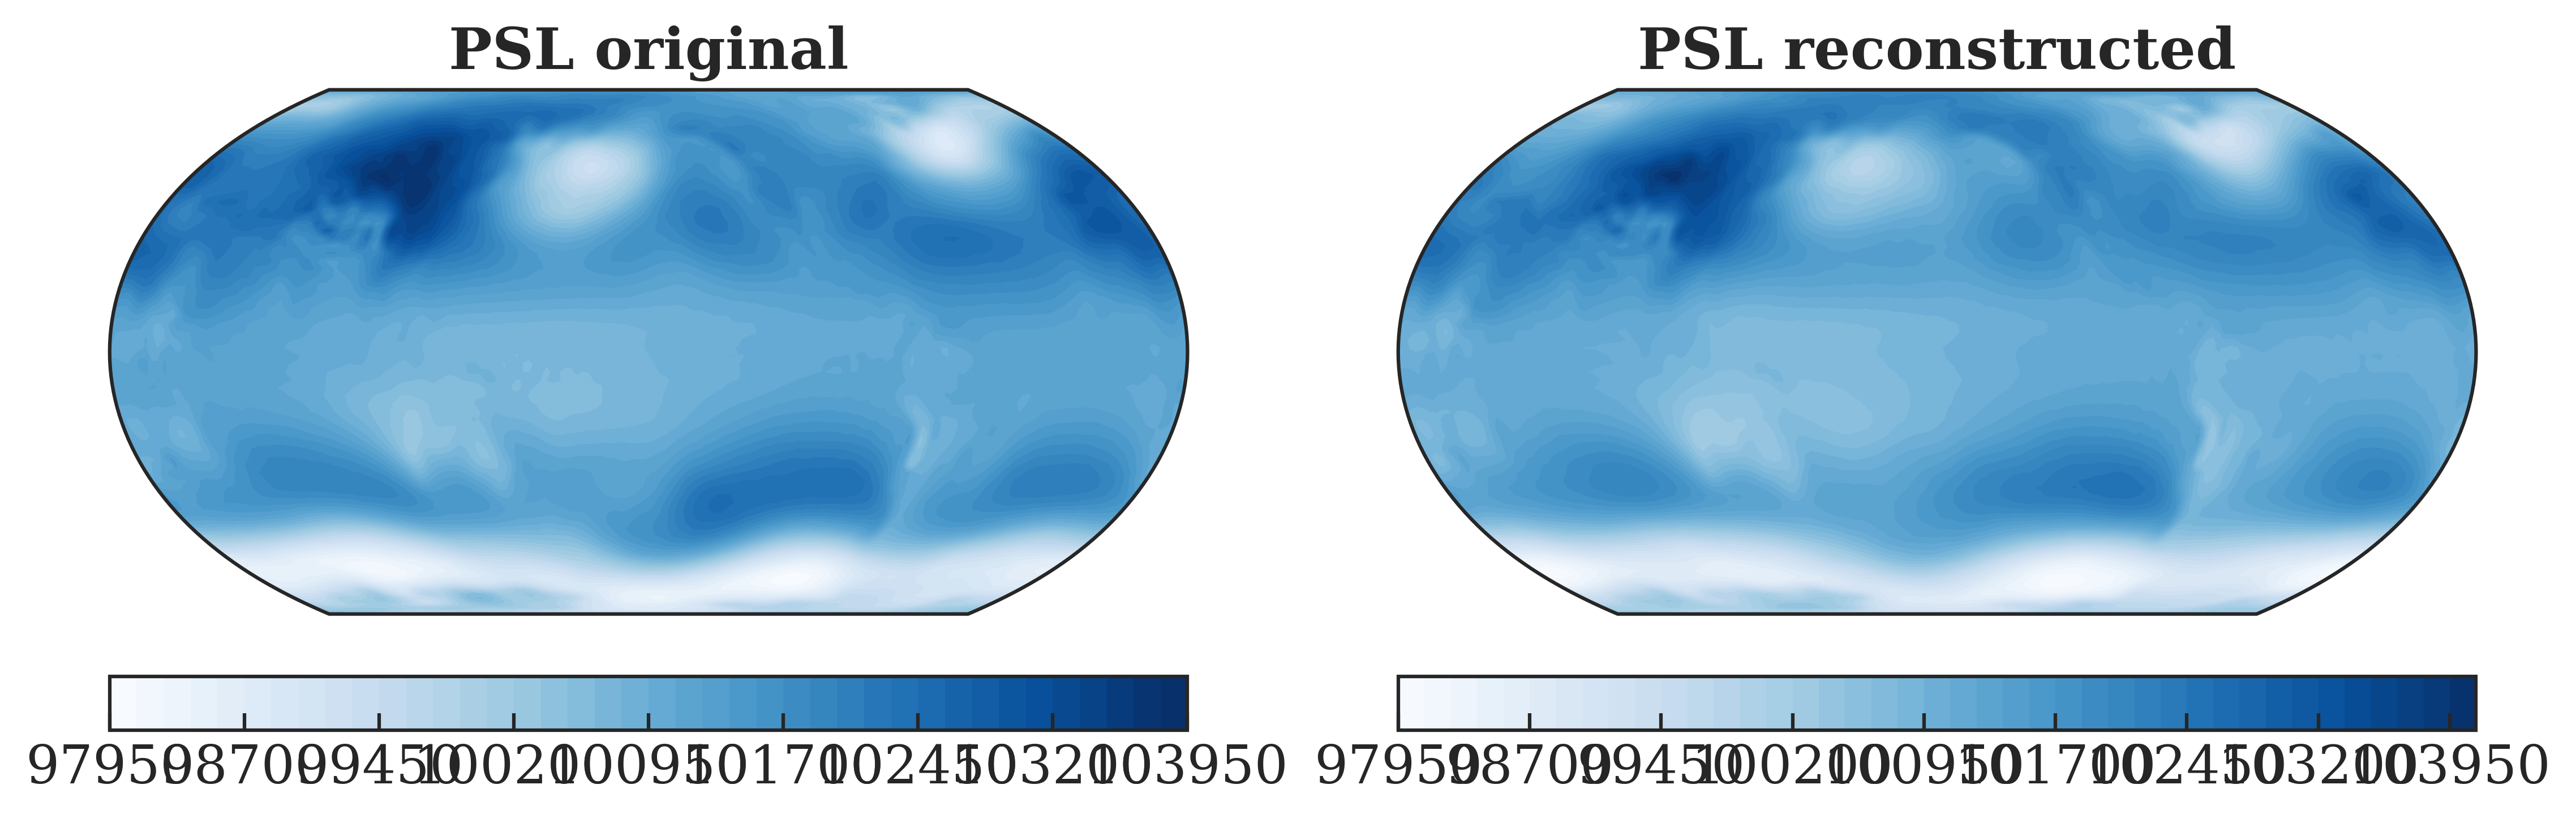

In [333]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("PSL original")
plot_field(axs[0], data.isel(time=0)["psl"])

axs[1].set_title("PSL reconstructed")
plot_field(axs[1], y.isel(time=0)["psl"])